# Optimizing Pricing & Supply

# Introduction

In this exercise we will explore some fundamentals related to revenue maximization and risk optimization.  

We will use Python, a highly flexible, powerful open source language.  Python has many great benefits including some nice data munging and mathematical optimization packages like **pandas** and **scipy** which we will leverage for this analysis.

The **goal of this analysis** is to:
* Setup and solve for the revenue maximizing price
* Increase revenue by pricing to different market segments
* Manage the uncertainty of demand through supply constraints

# Problem Data

In our analysis, a manager of a 500-cabin ski-lodge has conducted a survey to ascertain the value his customers place on staying at his establishment.  Ten respondents, comprising 1.4% of the ski-lodge's customer base were surveyed.  The distribution of "values" submitted by each surveyed customer is shown below. 

In our data:
* 'Customer' represents the individual customer surveyed
* 'Price' represents the maximum price that a customer would play on a ski-lodge stay
* 'Demand' represents the number of customers who would stay at the ski-lodge for the given value or price

In [1]:
import pandas as pd, numpy as np
survey = pd.DataFrame({'customer':np.arange(1,11,1),
                      'price':[445,187,746,328,432,212,63,98,241,601]})

In [2]:
survey['demand'] = ""
for idx,row in survey.iterrows():
    count = len(survey[survey['price']>=row['price']])
    survey.set_value(idx,'demand',count)

Leveraging scipy's **curve_fit** function which fits the best possible line to our data, we find that the best line has an equation of:

In [3]:
from scipy.optimize import curve_fit

def f(x, A, B):
    return A*x + B

A,B = curve_fit(f, np.array(survey['demand'].astype(float)), 
                np.array(survey['price'].astype(float)))[0]
print("p =",B,A,"* q")

p = 725.466666244 -70.9393938756 * q


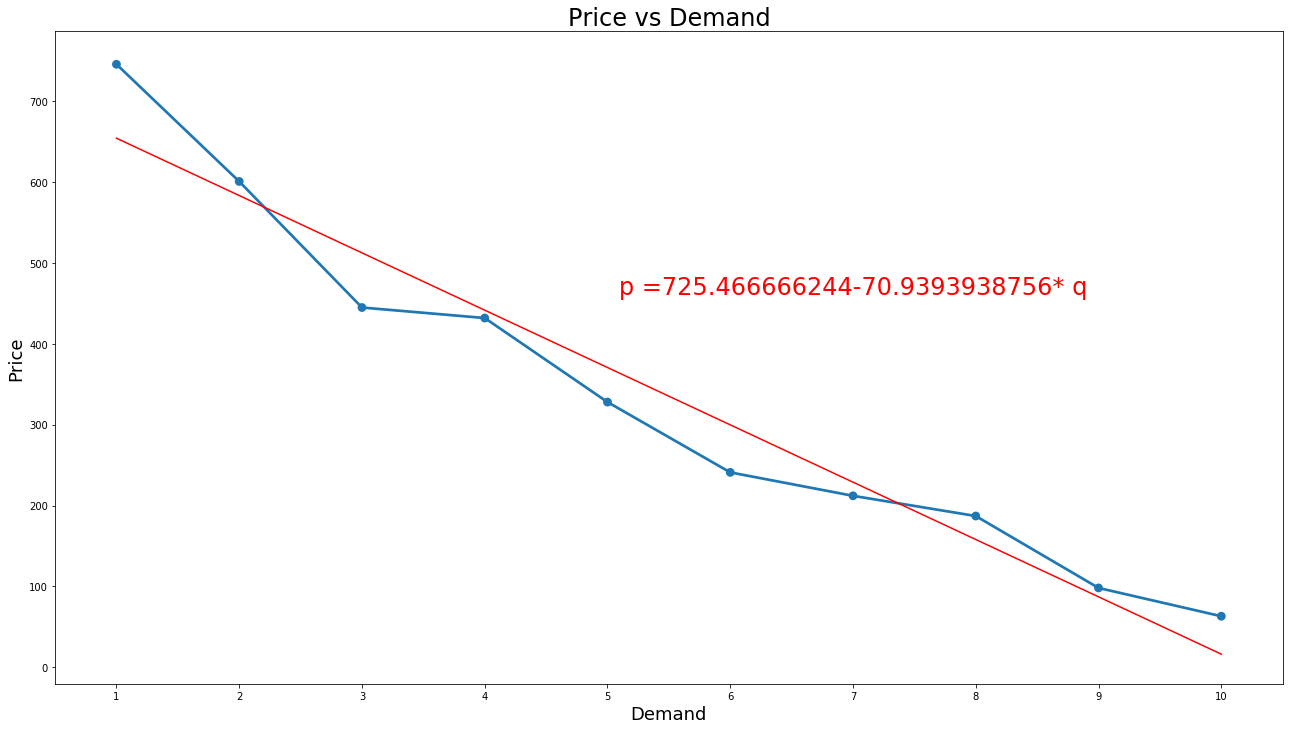

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(22,12)) 
ax = sns.pointplot(x="demand", y="price",data=survey);

ax.text(x=6, y=470,s="p ="+str(B)+str(A)+"* q", 
             ha='center', va='center',color="red",size=24)

ax.set_title('Price vs Demand', fontsize=24);
ax.set_ylabel('Price',fontsize=18);
ax.set_xlabel('Demand',fontsize=18);

def graph(x_range):  
    x = np.array(x_range)  
    y = B + A*(x+1)  # <- note now we're calling the function 'formula' with x
    plt.plot(x, y,c="r")  
    plt.show()  

graph(range(0, 10))

This is a function of price (p) as it relates to demand (q).  Therfore if we isolate q, we can observe for our demand function which is:

In [12]:
#isolating demand(q)
print("q = (",B,"- p)/",-A)

q = ( 725.466666244 - p)/ 70.9393938756


Furthermore, since the survey respondents only make up 2% of the total customers, we can multiply by 71 (100/1.4) to reach a total demand of:

In [13]:
#since the survey was only 2% of our demand, we multiply by 50 to get:
print("q =",B,"- p")

q = 725.466666244 - p


# Maximizing Revenue

Pricing can have a momentous affect when it comes to revenue management. To demonstrate the benefits of segmentation, we will first look at profits when a single price is charged to each customer.  The first question we must answer is:

**What is the optimal price we should charge to maximize revenue?**

Let's first create some functions.  Our demand function (q = 725 - p) can be rewritten in Python as:

In [14]:
def price(x,a=725):
    return (a-x)

Our objective function, revenue, can be written as the following, which is simply the product of demand and price.

In [15]:
def objective(x_t,a=725):
    return -1.0 * np.sum(x_t * price(x_t, a=a))

In the below chart, let's take a look at the possible values of revenue across different price points.  We can see that maximum revenue of around \$130K is achieved by pricing the ski-lodge cabins around \$350.

So how can we solve for this analytically to find the best price?

In [16]:
profits = [-1*objective(i) for i in range(1000)]
profits = pd.DataFrame(profits).reset_index()
profits.columns = ["price","revenue"]
profits = profits[profits['revenue']>0]

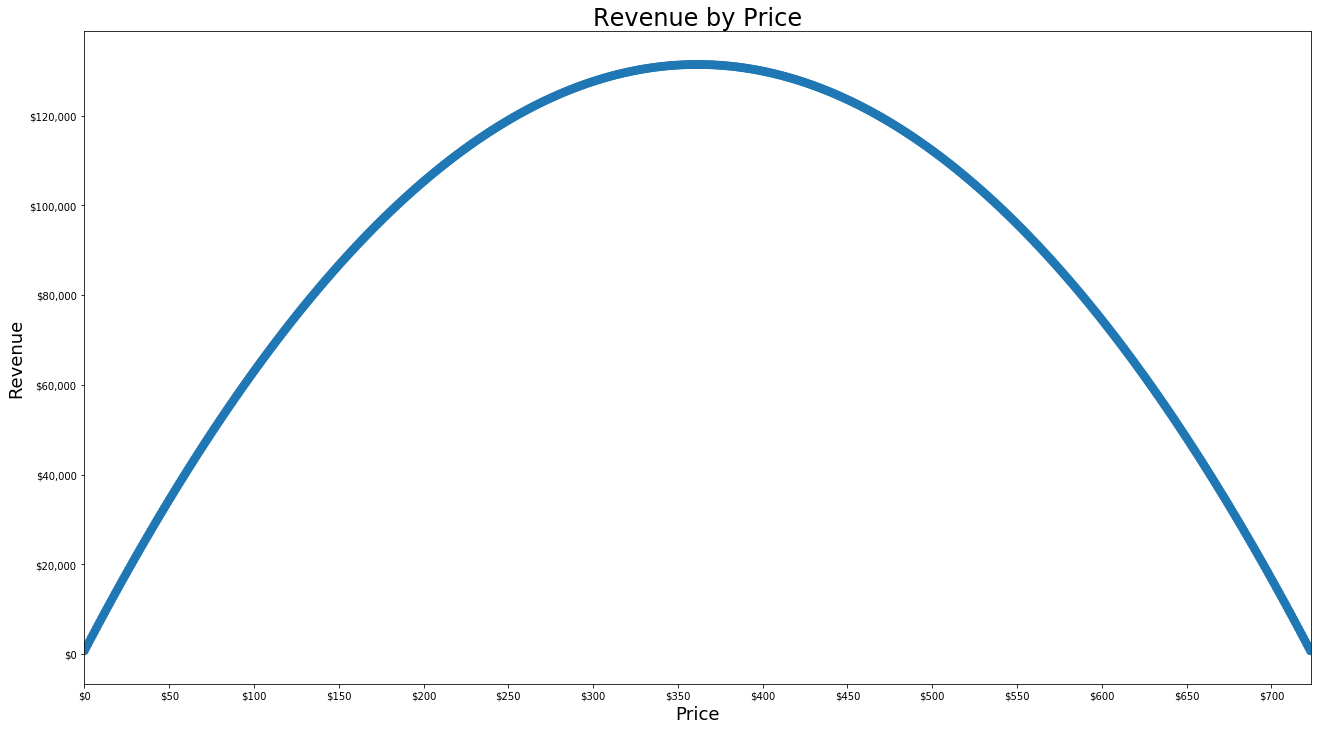

In [40]:
import matplotlib.ticker as mtick
fig, ax = plt.subplots(figsize=(22,12)) 
ax = sns.pointplot(x="price", y="revenue", data=profits);

labels = [0,50,100,150,200,250,300,350,400,450,500,550,600,650,700]
ax.set_xticks(labels)
ax.set_xticklabels(labels)
ax.set_title("Revenue by Price",fontsize=24)
fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 
ax.xaxis.set_major_formatter(tick) 
ax.set_ylabel("Revenue",fontsize=18)
ax.set_xlabel("Price",fontsize=18)

plt.show()

Scipy has an optimization method which will either minimize or maximize an objective function with a given method.  In this case, we will use **scipy.minimize** as we have negated the results of our objective function.  Therefore, this minimization solver will actually maximize our objective function.

We will also give scipy a starting value to begin its optimization from.

In [18]:
a = 725
x_start = 300

import scipy.optimize as optimize
opt_results = optimize.minimize(objective, x0=x_start, args=(a),
                            method='SLSQP', bounds="",  constraints="")

In [19]:
opt_results

     fun: -131406.25
     jac: array([ 0.])
 message: 'Optimization terminated successfully.'
    nfev: 7
     nit: 2
    njev: 2
  status: 0
 success: True
       x: array([ 362.5])

Upon successful completion of the optimization, we see that the optimal price to charge is:

In [20]:
print("$",np.sum(opt_results['x']))

$ 362.5


This results in a maximum demand of:

In [21]:
print("Demand: ",*price(opt_results['x'],a=a))

Demand:  362.5


This results in a maximum revenue of:

In [22]:
print("Revenue: $",-1*objective(opt_results['x'],a=a))

Revenue: $ 131406.25


# Introducing Segmentation

Segmentation is a tool managers can use to price discriminate and increase revenue.  The ski-lodge manager needs a way to (legally) enact price discrimination on its customers.  One such way is to charge higher prices for customers who book their cabins late and lower prices for customers who book their cabins early. 

Our question now becomes: **What is the optimal price we should charge our segment to maximize revenue?**

Our two segment thesis allows us to create following demand functions for our two segments:

In [23]:
print("Late Demand =(",725," - high price)",)
print("Early Demand =(",725," - low price) - ","(",725,"- high price)")

Late Demand =( 725  - high price)
Early Demand =( 725  - low price) -  ( 725 - high price)


We will create demand functions for these two segments as well as the objective function.

In [24]:
def price_high(x_high,a=725):
    return a-x_high

def price_low(x_high,x_low,a=725):
    return (a-x_low)-(a-x_high)

def objective2(x_t2,x_t,a=725):
    return -1.0 * np.sum((x_t * price_low(x_t2,x_t,a))+(x_t2 * price_high(x_t2,a)))

We will also create two constraints for our optimization:
* We want to actually sell cabins so we set a maximum combined price for both segments at 725.
* We want to sell an even number of cabins to each segment.

In [25]:
#create constraitn funcs for optimizer
def constraint1(x_start):
    e1 = x_start[0]
    e2 = x_start[1]    
    total = 725.0 - np.sum(x_start)
    return total

def constraint2(x_start):
    e1 = x_start[0]
    e2 = x_start[1]
    return price_low(e1,e2) - price_high(e1)

#create constraitn dicts for optimizer
con1 = {'type':'eq','fun':constraint1}
con2 = {'type':'eq','fun':constraint2}
cons = [con1,con2]

Once again, let's take a look at the potential revenue we can achieve from different combinations of our early and late booking prices.  We see that the maximum revenue is achieved by charging a late fee of around \$500 for the late price and \$250 for the early price.

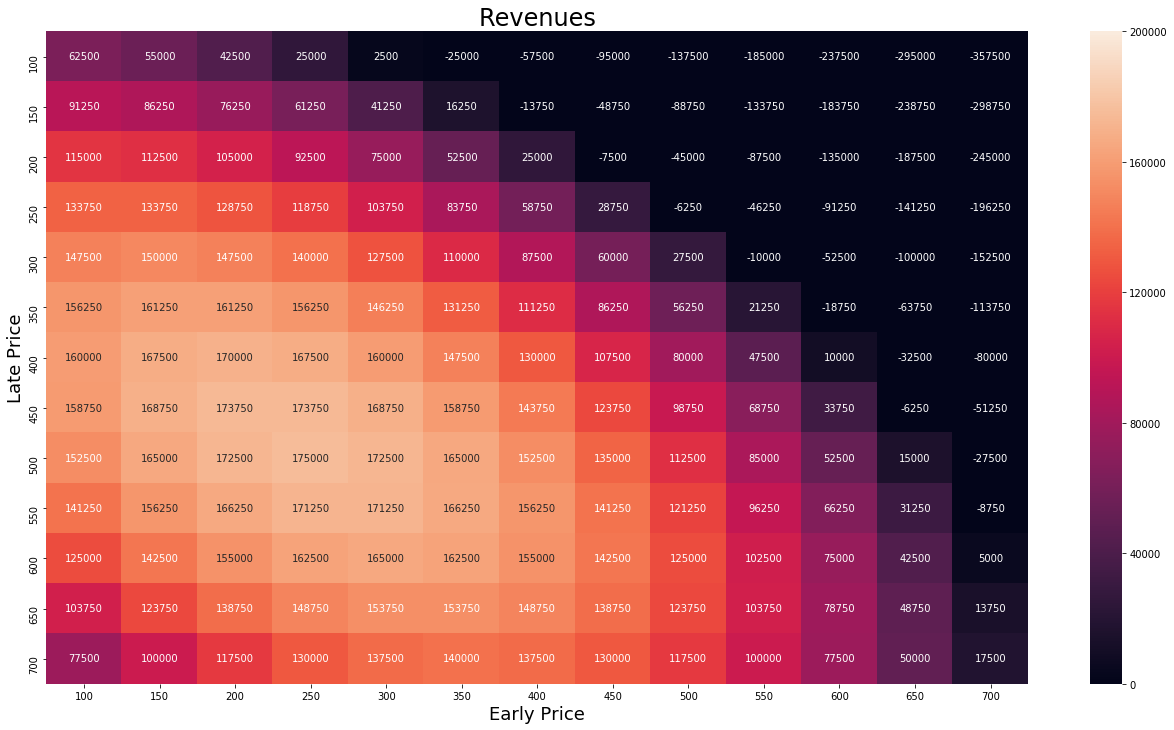

In [26]:
x = pd.DataFrame(index=np.arange(100,750,50),columns=list(np.arange(100,750,50)))
for col in x:
    for idx, row in x.iterrows():
        revenue = objective2(idx,col)
        x.set_value(idx,col,revenue)
x = x.astype(int)

import matplotlib.pyplot as plt 

fig, ax = plt.subplots(figsize=(22,12)) 
ax = sns.heatmap(-x,annot=True, fmt='g', vmin=0, vmax=200000)
ax.set_title('Revenues', fontsize=24);
ax.set_ylabel('Late Price',fontsize=18);
ax.set_xlabel('Early Price',fontsize=18);

Again, we setup the optimizer to maximize our objective function subject to our constraints. 

In [27]:
a = 725
x_start = (300,200)
x_low = x_start[0]
x_high = x_start[1]

import scipy.optimize as optimize
opt_results = optimize.minimize(objective2, x0=x_start, args=(a),
                            method='SLSQP', bounds="",  constraints=cons,
                               options={'maxiter': 10000, 'ftol': 1e-09})

Upon completion, we see that the best prices to charge for our segments are:

In [31]:
print('High Segment: $',opt_results['x'][0])
print('Low Segment: $',opt_results['x'][1])

High Segment: $ 483.333333333
Low Segment: $ 241.666666667


This results in a revenue of:

In [32]:
print('Revenue:$ ',-1*objective2(opt_results['x'][0],opt_results['x'][1]))

Revenue:$  175208.333333


# Managing Uncertainty

Thus far, we have known exactly how many customers would show up given a price we set (certain demand).  In the real world this is impossible, every demand estimation we create will have an accompanying level of variance.

To mitigate the risk of uncertainty, the ski-lodge manager may find it prudent to save a number of cabins for last minute bookings.  This way, he can hold these cabins out from early booking and charge late arrivals more for them.  

So how do we know how many cabins to allocate for early and late booking?

Let's make the following assumptions.
* The supply of cabins available for early booking will always be met with equal demand.
* The number of late booked cabins is unknown with a mean of 200 and a standard deviation of 50.  
* The advance cabin rate is \$200.
* The late cabin rate is \$300.

We can then create a base probability function f(Q) which is the probability of late bookings.
 * f(Q) = n_late >= Q
    * where Q is the number of cabins saved for late bookings

Since we are assuming that all cabins available for early booking will be booked, decreasing Q by 1 will give us an additional $200 in revenue as it will be booked early.  

However, based on our assumption about the probability of late bookings, the manager would lose (1 - f(Q) )* \$300 if he were to lower Q by 1.

Therefore, the manager should always save Q+1 cabins instead of Q cabins unless the potential revenue from the early booking outweighs the potential revenue from the late booking, or:

200 >= (1 - f(Q)) * 300


If we solve for f(Q), we get the following:

f(Q) >= 100/300 or **0.333**

Therefore, we should only save enough cabins to surpass the 33.3 percentile of the distribution of unknown late reservations.  Using the scipy **percent point function**.  We see that the ski-lodge manager should reserve the following number of cabins for late arrivals:

In [37]:
import scipy.stats as sct
print("Protected late cabins: ",round(sct.norm.ppf(q=0.333,loc=200,scale=50),0))

Protected late cabins:  178.0


Assuming the same level of demand, with a mean of 200 and a standard deviation of 50, let's explore the number of cabins the manager would have to protect for various price points.  

We see that, as the price of a late booking increases, the number of cabins to protect rises as these late booked cabins are worth comparably more.  Likewise, the cabin protection rate falls as the early booking prices increase as late booked cabins are worth comparably less.

In [38]:
def cabins(early_fee,late_fee):
    ptile = float((late_fee-early_fee)/late_fee)
    cabins = round(sct.norm.ppf(q=ptile,loc=200,scale=50),0)
    return cabins

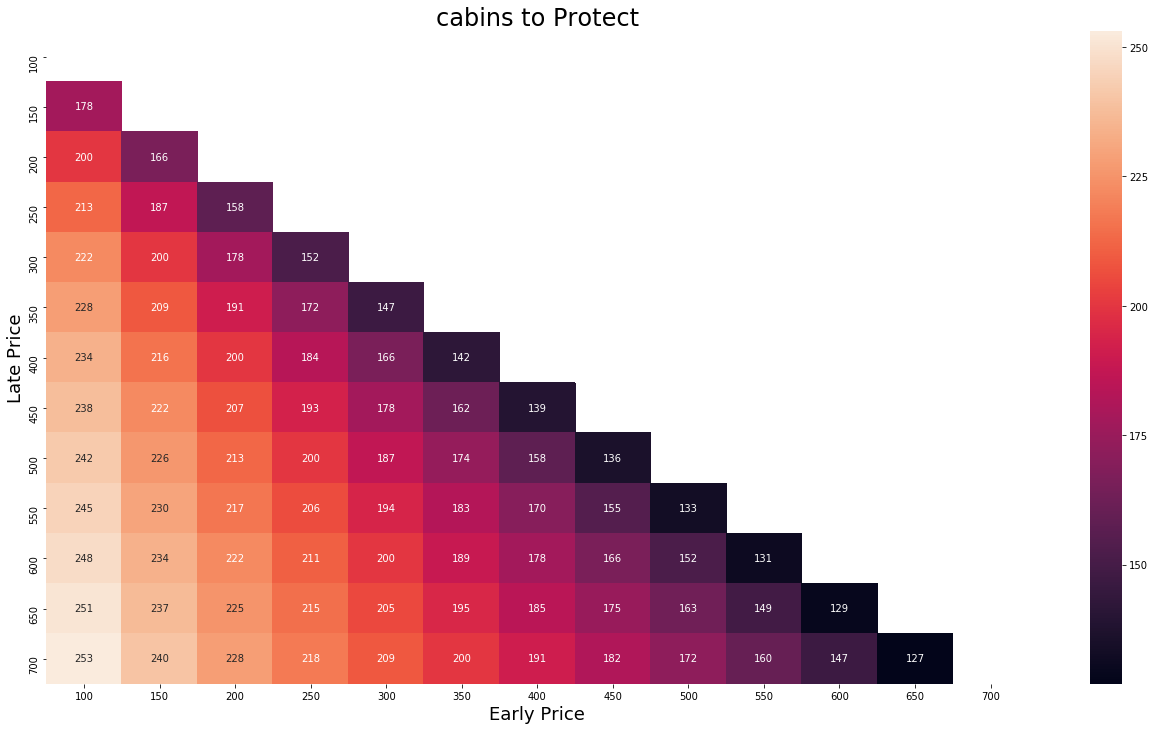

In [39]:
x = pd.DataFrame(index=np.arange(100,750,50),columns=list(np.arange(100,750,50)))
for col in x:
    for idx, row in x.iterrows():
        lol = cabins(float(col),float(idx))
        x.set_value(idx,col,lol)
x = x.astype(float)
x = x.replace([np.inf, -np.inf], np.nan)
mask=x.isnull()

fig, ax = plt.subplots(figsize=(22,12)) 
sns.heatmap(x, mask=mask,annot=True, fmt='g')
ax.set_title('cabins to Protect', fontsize=24);
ax.set_ylabel('Late Price',fontsize=18);
ax.set_xlabel('Early Price',fontsize=18);

# Conclusion

In this analysis, we've discussed some principles of revenue and risk optimization.  

We've talked about how revenue can be increased through segmentation.  

We also looked at how to deal with uncertainty in demand, which every manager will need to plan for in real world business applications.

I hope you enjoyed reading. -Collier King